# Reviews Topic Modeling

In [ ]:
# !pip install -q --disable-pip-version-check -r ../requirements.txt

In [ ]:
# Randomization for seed reproduction
import random

# Matrix operations
import numpy as np

# Dataframes
import pandas as pd

# Regular Expressions
import re

# Import unidecode (to remove accents from words)
from unidecode import unidecode

# Import wordcloud
from wordcloud import WordCloud

# Sklearn Utilities
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

# Visualize the information contained in a topic model
import pyLDAvis
from pyLDAvis import gensim as gensimvis

import gensim
from gensim import corpora

# Charts
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# SciKit Learn Utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.manifold import TSNE
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize

# Language Detection
from langdetect import detect


In [ ]:
# Set a random seed for reproducibility
random_seed = 10
np.random.seed(random_seed)
random.seed(random_seed)

---
## 1. Displaying initial data

In [ ]:
reviews_df = pd.read_csv('../data/Big_AHR.csv', index_col=0)
reviews_df.head()

Obtain an example from the dataset:

In [ ]:
def get_one_sample_with_columns(df, id=0):
    return list(zip(list(df.columns), list(df.iloc[id])))

Display the rating and the sentiment associated to the review:

In [ ]:
def display_ratings(df):
    rating = df['rating'].value_counts()

    fig = px.bar(
        x=rating.index,
        y=rating.values,
        labels={'x': 'Rating', 'y': 'Count'},
        title='Count of Each Unique Rating'
    )

    fig.show()

In [ ]:
def display_review_sentiment(df):
    SENTIMENT_CONVERSION = { 0: "Negative", 1: "Positive", 3: "Neutral" }

    sentiment_column = df['label'].value_counts().sort_index()

    fig = px.bar(
        # Convert numerical x-axis labels to string labels
        x=[SENTIMENT_CONVERSION[label] for label in sentiment_column.index],
        y=sentiment_column.values,
        labels={'x': 'Sentiment', 'y': 'Count'},
        title='Count of Each Unique Sentiment'
    )

    fig.show()

In [ ]:
# display_ratings(reviews_df)

In [ ]:
# display_review_sentiment(reviews_df)

As we can see, the dataset is completely unbalanced. There are almost 10x of 5-star ratings that 2-star ratings.

---
## 2. Text Preprocessing
We will discard everything but the review *review_text* as it is the only useful for the topic modelling process

In [ ]:
# Get every column and drop everything except for review_text
reviews_df = reviews_df.drop(reviews_df.columns.difference(['review_text']), axis=1)

reviews_df.head()

### 2.1. Removing NaN and missing values

In [ ]:
def has_nan_or_missing_values(df):
    # Check for NaN values
    nan_check = df.isna().any()

    # Check for empty values (assuming empty strings)
    empty_check = (df == '').any()

    # Combine the results to check for both NaN and empty values
    has_nan_or_empty = nan_check | empty_check

    print(has_nan_or_empty)
    print(f"Number of samples: {df.shape[0]}")

In [ ]:
has_nan_or_missing_values(reviews_df)

✅ Removing the NaN values resulted on also removing the NaN and missing values from the hotel attribute.

In [ ]:
get_one_sample_with_columns(reviews_df)

Obtain more information about the dataframe:

In [ ]:
reviews_df.info()

### 2.2. Text Preprocessing
We will only keep the Spanish reviews with the langdetect library. Otherwise, the TF_IDF matrix will be too sparse.

#### 2.2.1. Filter Spanish reviews

In [ ]:
# Remove all non-Spanish reviews
# reviews_df = reviews_df[reviews_df['review_text'].apply(lambda x: detect(x) == 'es')]
# reviews_df.info()

In [ ]:
# Reset the indeces
# reviews_df = reviews_df.reset_index(drop=True)

In [ ]:
# Save the dataframe to a CSV file
# reviews_df.to_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv')

In [ ]:
# Import the CSV file
reviews_df = pd.read_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv', index_col=0)

reviews_df.head()

#### 2.2.2. Remove punctuation

In [ ]:
# Remove punctuation using regular expressions
# We just keep the words and spaces
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

reviews_df.head()

#### 2.2.3. Transform text to lowercase

In [ ]:
# Transform all words to lowercase (consistency)
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: x.lower())

reviews_df.head()

#### 2.2.4. Remove Stopwords

In [ ]:
nltk.download('stopwords')

In [ ]:
from nltk.corpus import stopwords

In [ ]:
# Initialize stopwords
stop_words = set(stopwords.words('spanish'))

# Define the text preprocessing function
def remove_stop_words(text):
    # Remove stop words
    words = text.split()  # Split text into words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

In [ ]:
# preprocess the df
reviews_df['review_text'] = reviews_df['review_text'].apply(remove_stop_words)

reviews_df.head()

#### 2.2.5. Remove non-spanish words
Delete not spanish words or misspelled words that lead to errors and confusion
##### 3 hours to execute, please don't. Instead use the file Reduced_Topic_Modelling_Big_AHR_Spanish.csv

In [ ]:
# from concurrent.futures import ThreadPoolExecutor
# from spellchecker import SpellChecker

# spanish = SpellChecker(language='es')

# def fix_non_words(text: str, column_n) -> str:
#     corrected_words = [spanish.correction(word) if spanish.correction(word) else '' for word in text.split()]
#     # print(f'{text} -> {corrected_words}')
#     return ' '.join(corrected_words)

# # Define the number of threads you want to use
# num_threads = 12

# # Create a ThreadPoolExecutor with the specified number of threads
# with ThreadPoolExecutor(max_workers=num_threads) as executor:
#     # Use the executor to apply the fix_non_words function to each element in the 'review_text' column concurrently
#     reviews_df['review_text'] = list(executor.map(fix_non_words, reviews_df['review_text'], reviews_df.index))


# save the dataframe to a CSV file
# reviews_df.to_csv('../data/Reduced_Topic_Modelling_Big_AHR_Spanish.csv')

In [ ]:
reviews_df = pd.read_csv('../data/Reduced_Topic_Modelling_Big_AHR_Spanish.csv', index_col=0)

reviews_df.head()

#### 2.2.4. Remove accents - deprecated
With the application of the spellchecker, there is no need to remove accents.

As we are processing a latin language, is important to strip accents and special characters in order to generalize better

In [ ]:
# reviews_df['review_text'] = reviews_df['review_text'].apply(unidecode)

# reviews_df.head()

#### 2.2.5. Remove single character words
Problem detected in the exploratory analysis. 

In [ ]:
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

---
## 3. Exploratory analysis
Show wordcloud to visualize possible problems in the data

### 3.1. Wordcloud

In [ ]:
def generate_wordcloud(df, column_name, name='wordcloud', random_seed=None):
    # Join all reviews into a single string
    all_reviews = " ".join(df[column_name])

    # Generate the word cloud with the specified random seed
    wordcloud = WordCloud(
        width=1600, height=800, max_font_size=200, background_color="white", colormap="magma",
        random_state=random_seed
    ).generate(all_reviews)

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots(figsize=(16, 8), facecolor="white")

    # Add the title
    plt.title('Word Cloud for Reviews', fontsize=24, pad=20, color='black', fontweight='medium')

    # Display the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

    # Save the generated image
    plt.savefig(f'../images/{name}.png')
    
    # Show the generated image
    plt.show()

In [ ]:
# generate_wordcloud(reviews_df, "review_text", "wordcloud_pre_manual", random_seed)

### 3.2. Manual review

In [ ]:
# Delete words that may be due to errors
wrong_words = ['ma', 'asi', 'una', 'aunque', 'además', 'hace', 'etc', 'q', 'pue', 'si', 'tan', 'sido']
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in wrong_words]))

In [ ]:
generate_wordcloud(reviews_df, "review_text", 'wordcloud_post_manual', random_seed)

## 4. Latent Dirichlet Allocation

### 4.1. Tokenize words

In [ ]:
# Download the resources for NLTK spanish tokenizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

In [ ]:
# Tokenize the reviews if they are not already tokenized
tokens_df = reviews_df.copy()

tokens_df['review_text'] = tokens_df['review_text'].apply(lambda x: word_tokenize(x, language='spanish') if isinstance(x, str) else x)

### 4.2. Corpus & Dictionaries

In [ ]:
# Tokenize the reviews if they are not already tokenized
tokens_df["review_text"] = tokens_df["review_text"].apply(
    lambda x: word_tokenize(x, language="spanish") if isinstance(x, str) else x
)

# Create Dictionary
id2word = corpora.Dictionary(tokens_df["review_text"])

# Create Corpus
texts = tokens_df["review_text"]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

---
## 5. Latent Dirichlet Allocation Training

### 5.1. Output functions

#### 5.1.1. Topic Wordclouds

In [200]:
def create_topic_wordclouds(lda_model, name, num_topics):
    for topic_num in range(num_topics):
        # Get the words associated with the topic
        topic_words = lda_model.show_topic(topic_num, topn=20)
        # Create a dictionary of topic words and their probabilities
        topic_word_dict = {word: prob for word, prob in topic_words}
        
        # Generate a word cloud for the topic
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_word_dict)
        
        # Display the word cloud for the topic
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Topic {topic_num + 1} Word Cloud')
        plt.axis("off")
        plt.savefig(f'../images/topic_{name}_{topic_num + 1}_wordcloud.png')


In [201]:
import matplotlib.colors as mcolors


def create_multiple_topic_wordclouds(
    lda_model, num_topics, width=2500, height=1800, max_words=20
):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    cloud = WordCloud(
        background_color="white",
        width=width,
        height=height,
        max_words=max_words,
        colormap="tab10",
    )

    topics = lda_model.show_topics(formatted=False)

    # Calculate the number of rows for subplots
    num_rows = (num_topics + 1) // 2

    # Create subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_topics:
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            ax.imshow(cloud)
            ax.set_title("Topic " + str(i), fontdict=dict(size=16))
            ax.axis("off")
        else:
            # Remove extra subplots if there are more than 'num_topics'
            fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

#### 5.1.2. Intertopic Distance Map

In [202]:
def intertopic_distance(lda_model, name, corpus):
  pyLDAvis.enable_notebook()
  vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
  pyLDAvis.save_html(vis, f'../images/{name}.html')
  return vis

### 5.2. LDA Model 1. 10 Topics

Better to use gensim library rather than scykitlearn

In [203]:
# number of topics
num_topics = 10

# Build LDA model
lda_model1 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=10,)
# Print the Keyword in the 10 topics
print(lda_model1.print_topics())
doc_lda = lda_model1[corpus]

[(0, '0.028*"hotel" + 0.017*"bien" + 0.017*"habitación" + 0.007*"centro" + 0.007*"personal" + 0.007*"desayuno" + 0.007*"bastante" + 0.006*"cama" + 0.006*"buen" + 0.006*"recepción"'), (1, '0.018*"hotel" + 0.012*"habitaciones" + 0.011*"habitación" + 0.008*"personal" + 0.008*"bien" + 0.007*"ubicación" + 0.007*"buena" + 0.006*"centro" + 0.006*"zona" + 0.005*"recepción"'), (2, '0.019*"hotel" + 0.013*"personal" + 0.013*"habitación" + 0.011*"bien" + 0.010*"desayuno" + 0.007*"habitaciones" + 0.007*"amable" + 0.006*"centro" + 0.006*"buena" + 0.004*"todas"'), (3, '0.024*"hotel" + 0.012*"ubicación" + 0.011*"habitación" + 0.010*"personal" + 0.009*"habitaciones" + 0.008*"desayuno" + 0.007*"bien" + 0.007*"precio" + 0.006*"cerca" + 0.006*"buena"'), (4, '0.028*"hotel" + 0.013*"habitación" + 0.009*"bien" + 0.008*"habitaciones" + 0.007*"personal" + 0.006*"limpieza" + 0.006*"desayuno" + 0.005*"centro" + 0.005*"excelente" + 0.005*"noche"'), (5, '0.016*"hotel" + 0.013*"habitación" + 0.009*"habitaciones" + 

#### 5.2.1. Output

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will 

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  ori

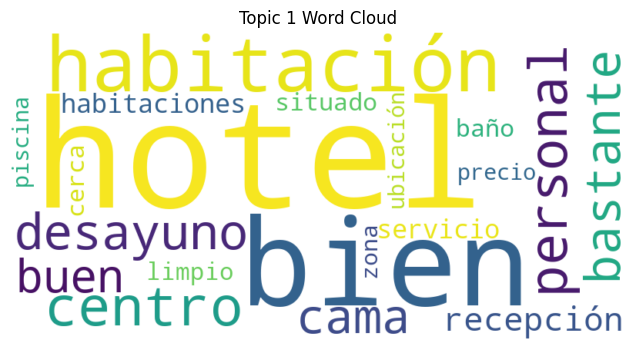

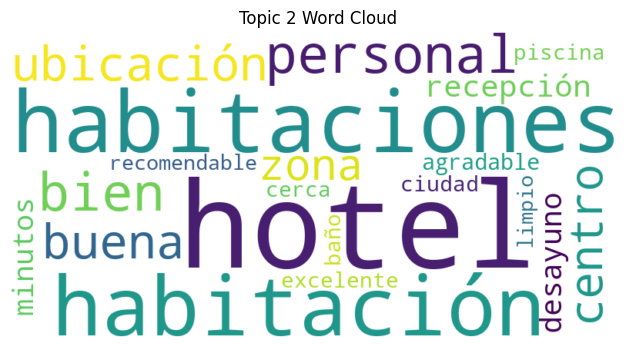

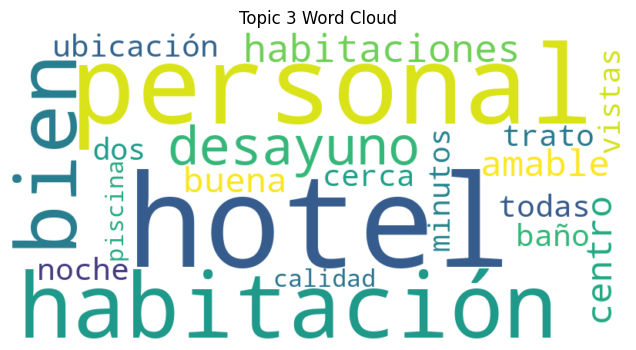

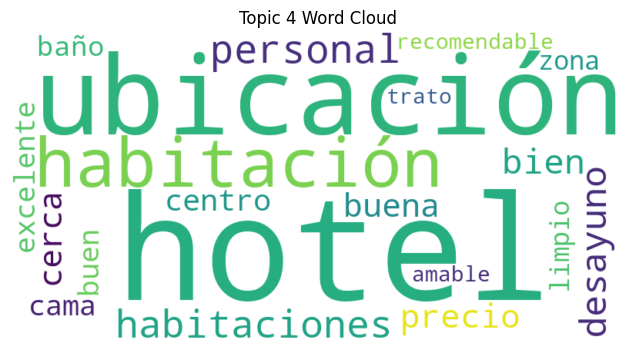

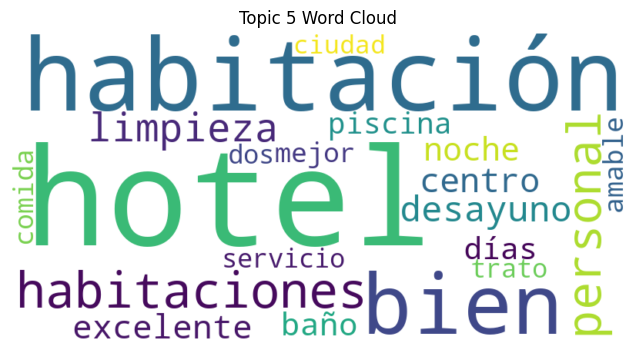

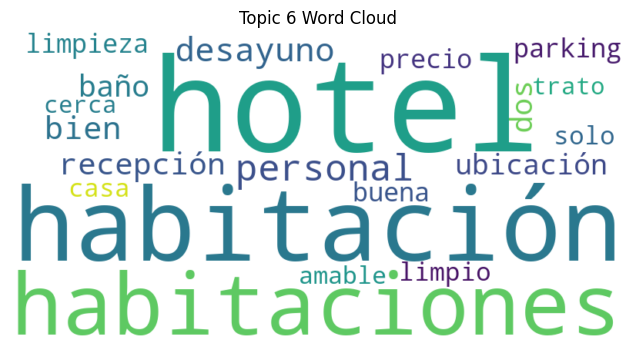

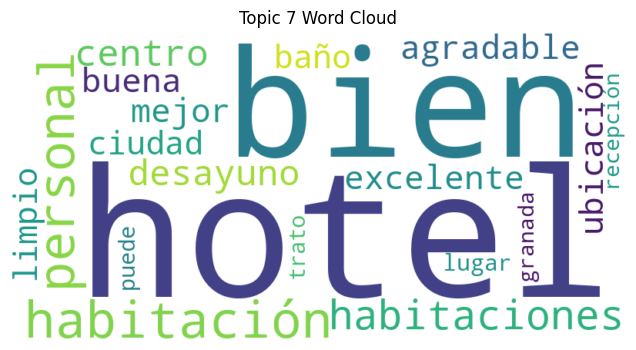

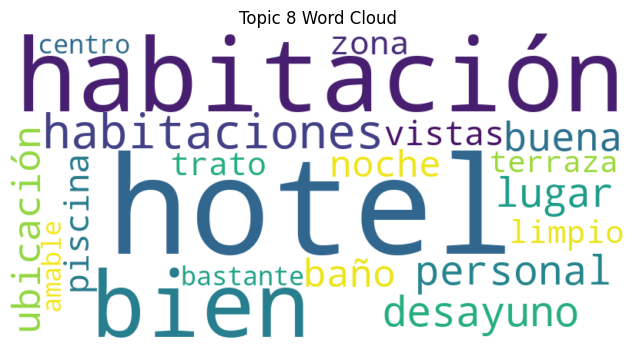

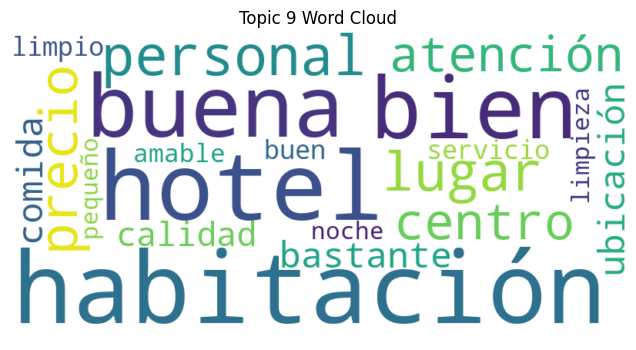

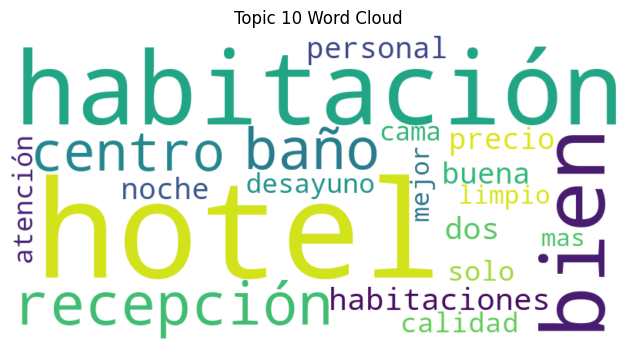

In [204]:
create_topic_wordclouds(lda_model1, 'lda_model1', num_topics)

In [205]:
# create_multiple_topic_wordclouds(lda_model1, num_topics)

In [206]:
intertopic_distance(lda_model1, 'lda_model1', corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.008428  0.010757       1        1  14.059744
6     -0.009089  0.007597       2        1  13.171288
3     -0.013577  0.009389       3        1  12.156354
2     -0.008188  0.007391       4        1  10.785926
5     -0.007958 -0.001258       5        1  10.382156
4      0.000514 -0.018355       6        1   9.038866
0     -0.002511 -0.009912       7        1   8.609852
9      0.010931 -0.035702       8        1   8.415881
1     -0.010888  0.012780       9        1   7.845034
8      0.049194  0.017312      10        1   5.534899, topic_info=             Term          Freq         Total Category  logprob  loglift
8           hotel  13597.000000  13597.000000  Default  30.0000  30.0000
21          buena   3589.000000   3589.000000  Default  29.0000  29.0000
95           bien   7028.000000   7028.000000  Default  28.0000  28.0000
7      habitación   8759.000000   8759.000000  Default  27.0000  27.0000
16      ubicación   3660.000000   3660.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
105  recomendable    100.962834   1783.740898  Topic10  -5.8966   0.0224
74   habitaciones    116.143626   5259.447068  Topic10  -5.7566  -0.9189
388       piscina    103.164847   2198.455817  Topic10  -5.8751  -0.1651
94           baño    107.294262   3261.929955  Topic10  -5.8358  -0.5204
5        desayuno    105.295423   4368.871446  Topic10  -5.8546  -0.8314

[859 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
14574      9  0.679417            3108
11919      7  0.696685        aceptaba
3883       2  0.669473      acomodadas
11385      7  0.696022         acomodo
18021      2  0.807554  acompañamiento
...      ...       ...             ...
82         6  0.075797           único
82         7  0.066468           único
82         8  0.058305           único
82         9  0.069966           único
82        10  0.050143           único

[2370 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 4, 3, 6, 5, 1, 10, 2, 9])

### 5.3. LDA Model 2. 10 Topics with Parameter Tunning

In [207]:
# number of topics
num_topics = 10

# Define LDA model parameters
lda_params = {
    'corpus': corpus,
    'id2word': id2word,
    'num_topics': num_topics,
    'random_state': 10,  # Reproducibility seed
    'passes': 30,  # Increase the number of passes for better convergence
    'eta': 'auto',  # Automatically set eta
}

# Build LDA model
lda_model2 = gensim.models.LdaMulticore(**lda_params)

# Print the Keyword in the 10 topics
print(lda_model2.print_topics())
doc_lda = lda_model2[corpus]

[(0, '0.031*"hotel" + 0.030*"habitación" + 0.025*"bien" + 0.012*"bastante" + 0.009*"cama" + 0.008*"desayuno" + 0.008*"baño" + 0.006*"recepción" + 0.006*"parking" + 0.006*"centro"'), (1, '0.022*"hotel" + 0.014*"habitaciones" + 0.011*"zona" + 0.010*"bien" + 0.009*"centro" + 0.008*"personal" + 0.008*"minutos" + 0.008*"buena" + 0.007*"agradable" + 0.006*"coche"'), (2, '0.015*"hotel" + 0.012*"habitación" + 0.010*"personal" + 0.010*"desayuno" + 0.009*"bien" + 0.005*"habitaciones" + 0.005*"amable" + 0.005*"todas" + 0.005*"noche" + 0.004*"piscina"'), (3, '0.028*"hotel" + 0.017*"personal" + 0.015*"ubicación" + 0.014*"bien" + 0.013*"buena" + 0.013*"centro" + 0.012*"habitación" + 0.012*"desayuno" + 0.012*"habitaciones" + 0.010*"cerca"'), (4, '0.028*"hotel" + 0.009*"habitación" + 0.007*"habitaciones" + 0.006*"bien" + 0.006*"piscina" + 0.005*"comida" + 0.004*"día" + 0.004*"noche" + 0.004*"días" + 0.004*"limpieza"'), (5, '0.014*"habitación" + 0.008*"hotel" + 0.008*"dos" + 0.007*"recepción" + 0.007*"

#### 5.3.1. Output

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will 

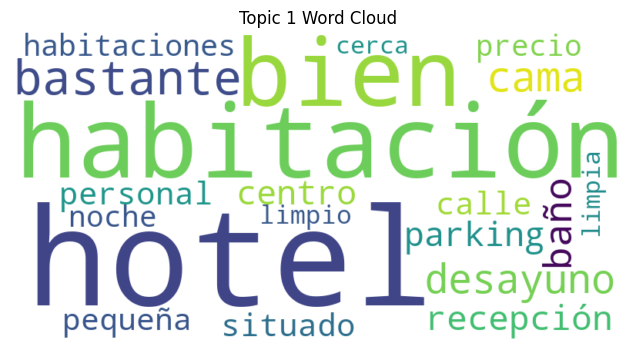

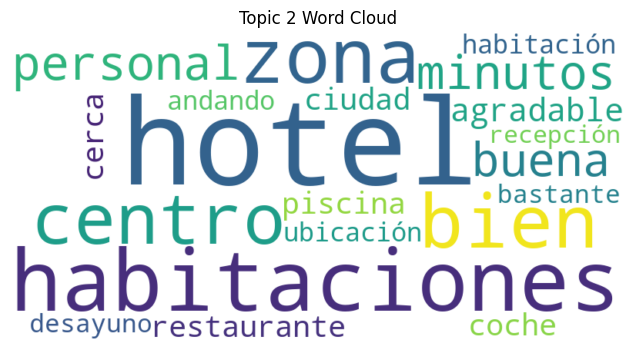

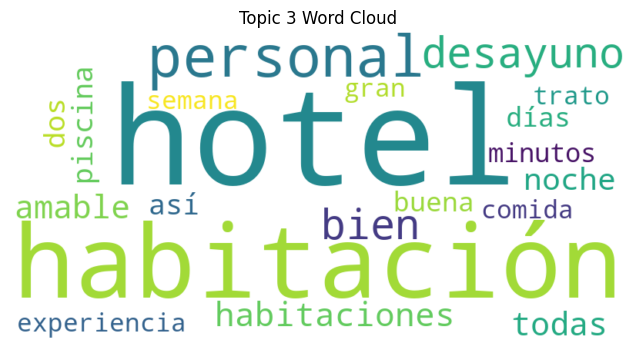

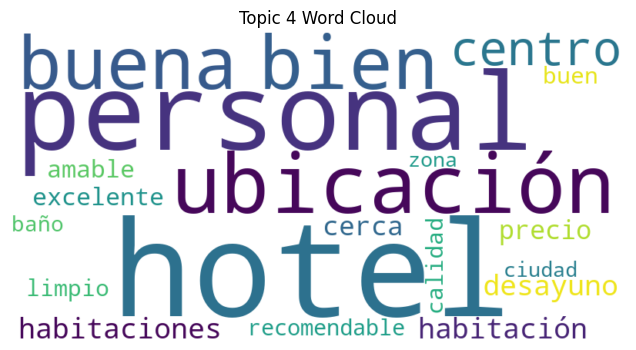

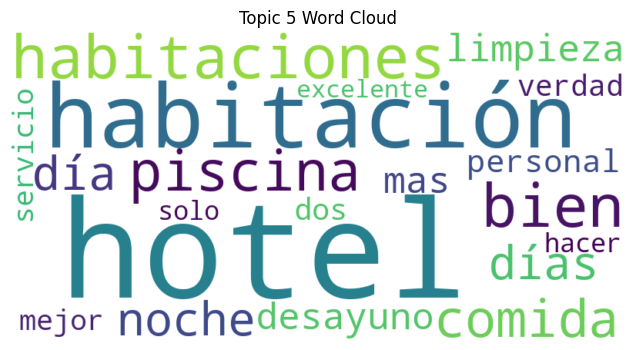

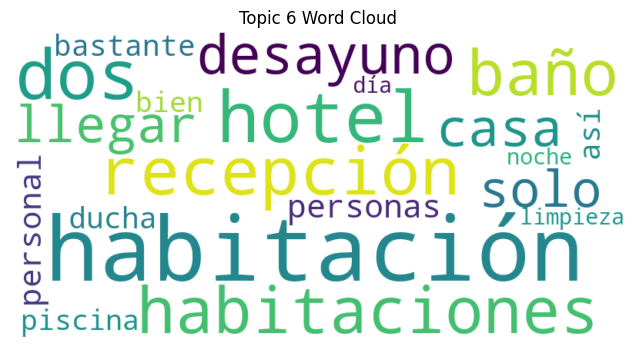

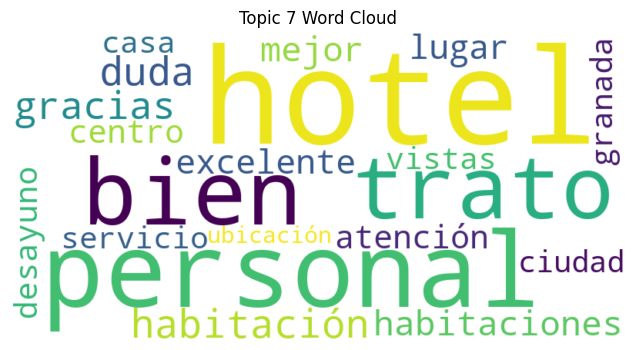

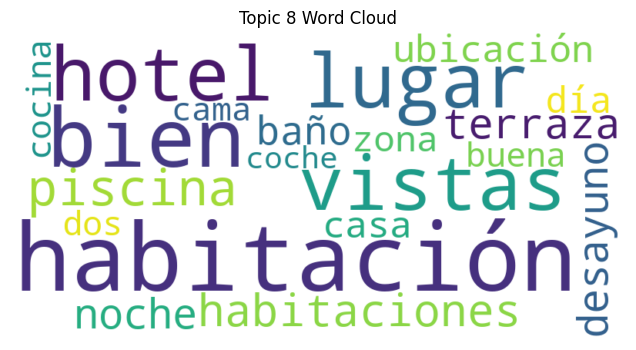

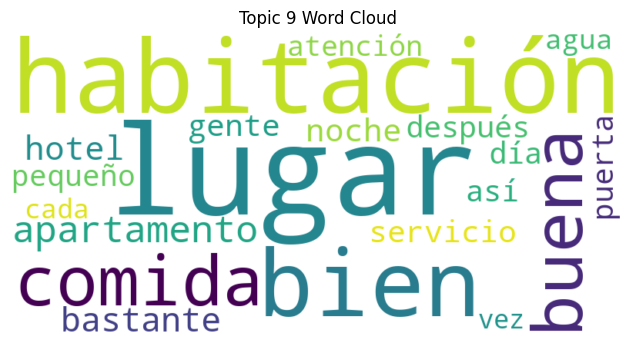

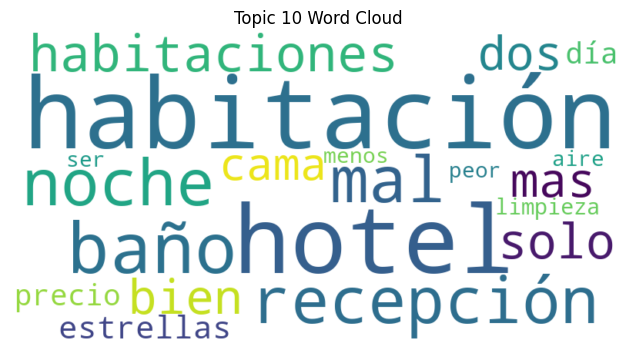

In [208]:
create_topic_wordclouds(lda_model2, 'lda_model2', num_topics)

In [209]:
# create_multiple_topic_wordclouds(lda_model2, num_topics)

In [210]:
intertopic_distance(lda_model2, 'lda_model2', corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.128419  0.038135       1        1  21.681480
9      0.143048  0.077635       2        1  15.211152
6     -0.110219 -0.039132       3        1  14.862439
7     -0.023942 -0.026560       4        1   9.547049
0      0.009841  0.076420       5        1   7.896939
1     -0.090088  0.010049       6        1   7.299259
5      0.066027  0.015751       7        1   7.054612
2     -0.010779 -0.020432       8        1   6.489830
4      0.053106  0.005442       9        1   6.191219
8      0.091425 -0.137308      10        1   3.766021, topic_info=            Term          Freq         Total Category  logprob  loglift
8          hotel  13782.000000  13782.000000  Default  30.0000  30.0000
7     habitación   8867.000000   8867.000000  Default  29.0000  29.0000
95          bien   7106.000000   7106.000000  Default  28.0000  28.0000
84      bastante   2149.000000   2149.000000  Default  27.0000  27.0000
75         lugar   2294.000000   2294.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
773         casa     61.529538   1497.009290  Topic10  -6.0068   0.0874
183          ser     59.794362   1383.678248  Topic10  -6.0354   0.1376
503       precio     64.573673   2844.373817  Topic10  -5.9585  -0.5061
252          dos     60.931090   2392.102302  Topic10  -6.0166  -0.3910
2557     granada     56.175951   1502.320036  Topic10  -6.0978  -0.0071

[921 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
19510      3  0.937529     1340
14737      5  0.859130      240
14929      6  0.938161  abarcan
2511       3  0.829894   abrazo
2511       4  0.079037   abrazo
...      ...       ...      ...
8799       1  0.031001    ángel
8799       3  0.806036    ángel
8799       4  0.093004    ángel
8799       5  0.031001    ángel
8799       7  0.031001    ángel

[3270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 7, 8, 1, 2, 6, 3, 5, 9])

### 5.4. LDA Model 3. 4 Topics

In [211]:
# number of topics
num_topics = 4

# Build LDA model
lda_model3 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=10,)

# Print the Keyword in the 10 topics
print(lda_model3.print_topics())
doc_lda = lda_model3[corpus]

[(0, '0.025*"hotel" + 0.016*"habitación" + 0.015*"bien" + 0.006*"personal" + 0.006*"centro" + 0.006*"bastante" + 0.006*"desayuno" + 0.005*"recepción" + 0.005*"habitaciones" + 0.005*"buen"'), (1, '0.018*"hotel" + 0.012*"habitación" + 0.011*"habitaciones" + 0.008*"bien" + 0.008*"personal" + 0.007*"buena" + 0.006*"ubicación" + 0.006*"recepción" + 0.005*"centro" + 0.005*"baño"'), (2, '0.018*"hotel" + 0.013*"habitación" + 0.011*"personal" + 0.011*"bien" + 0.009*"desayuno" + 0.007*"habitaciones" + 0.006*"centro" + 0.006*"buena" + 0.005*"amable" + 0.005*"noche"'), (3, '0.022*"hotel" + 0.012*"habitación" + 0.009*"ubicación" + 0.009*"habitaciones" + 0.008*"personal" + 0.008*"bien" + 0.007*"desayuno" + 0.006*"precio" + 0.006*"buena" + 0.005*"baño"')]


#### 5.4.1. Output

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will 

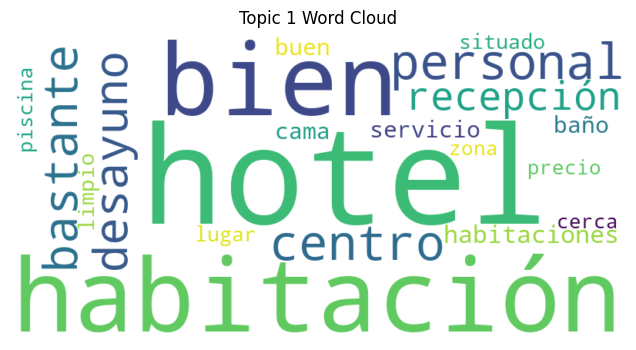

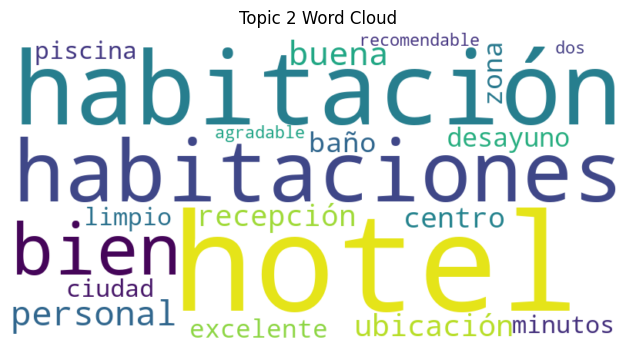

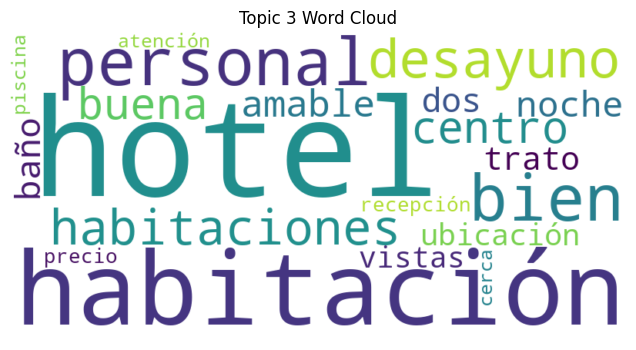

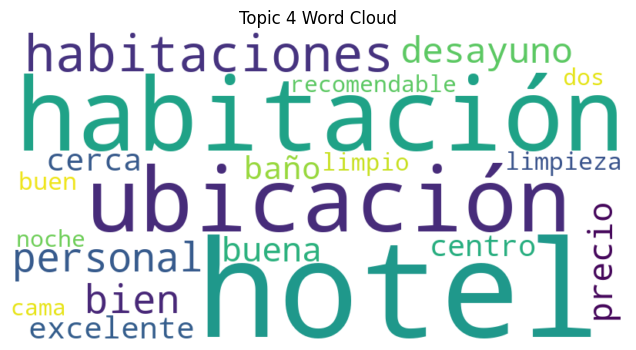

In [212]:
create_topic_wordclouds(lda_model3, 'lda_model3', num_topics)

In [213]:
# create_multiple_topic_wordclouds(lda_model3, num_topics)

In [214]:
intertopic_distance(lda_model3, 'lda_model3', corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.010472  0.008015       1        1  28.305346
2     -0.001750 -0.016335       2        1  28.284704
0      0.017515  0.004357       3        1  22.773227
1     -0.005292  0.003964       4        1  20.636723, topic_info=             Term          Freq         Total Category  logprob  loglift
95           bien   7052.000000   7052.000000  Default  30.0000  30.0000
16      ubicación   3634.000000   3634.000000  Default  29.0000  29.0000
8           hotel  13587.000000  13587.000000  Default  28.0000  28.0000
84       bastante   2155.000000   2155.000000  Default  27.0000  27.0000
74   habitaciones   5225.000000   5225.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
201      atención    416.111546   2052.464426   Topic4  -5.7964  -0.0177
3           cerca    458.106230   2594.739355   Topic4  -5.7003  -0.1560
333         noche    445.485845   2517.651996   Topic4  -5.7282  -0.1538
503        precio    442.544994   2762.263952   Topic4  -5.7348  -0.2532
0          amable    431.191424   2470.482630   Topic4  -5.7608  -0.1675

[372 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
14574      4  0.710802     3108
14929      1  0.133710  abarcan
14929      3  0.133710  abarcan
14929      4  0.802261  abarcan
11385      3  0.683992  acomodo
...      ...       ...      ...
111        4  0.283326     zona
82         1  0.417214    único
82         2  0.222046    único
82         3  0.184649    único
82         4  0.177637    único

[684 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

### 5.5. LDA Model 4. 4 Topics with Parameter Tunning

In [215]:
# number of topics
num_topics = 4

# Define LDA model parameters
lda_params = {
    'corpus': corpus,
    'id2word': id2word,
    'num_topics': num_topics,
    'random_state': 10,  # Reproducibility seed
    'passes': 30,  # Increase the number of passes for better convergence
    'eta': 'auto',  # Automatically set eta
}

# Build LDA model
lda_model4 = gensim.models.LdaMulticore(**lda_params)

# Print the Keyword in the 10 topics
print(lda_model4.print_topics())
doc_lda = lda_model4[corpus]

[(0, '0.020*"habitación" + 0.019*"hotel" + 0.009*"bien" + 0.007*"baño" + 0.006*"recepción" + 0.006*"habitaciones" + 0.005*"noche" + 0.005*"bastante" + 0.005*"cama" + 0.004*"mal"'), (1, '0.017*"hotel" + 0.008*"habitaciones" + 0.008*"bien" + 0.008*"lugar" + 0.007*"personal" + 0.007*"piscina" + 0.006*"trato" + 0.006*"estancia" + 0.005*"vistas" + 0.005*"gracias"'), (2, '0.011*"habitación" + 0.010*"hotel" + 0.006*"personal" + 0.006*"desayuno" + 0.006*"bien" + 0.005*"noche" + 0.005*"dos" + 0.005*"casa" + 0.005*"lugar" + 0.004*"día"'), (3, '0.028*"hotel" + 0.015*"bien" + 0.015*"personal" + 0.013*"habitación" + 0.012*"centro" + 0.011*"habitaciones" + 0.011*"desayuno" + 0.011*"ubicación" + 0.010*"buena" + 0.008*"cerca"')]


#### 5.2.1. Output

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will 

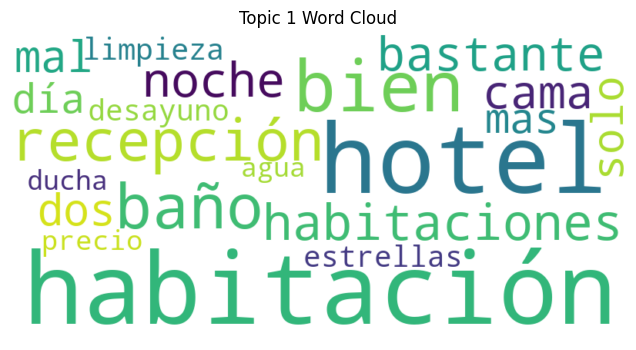

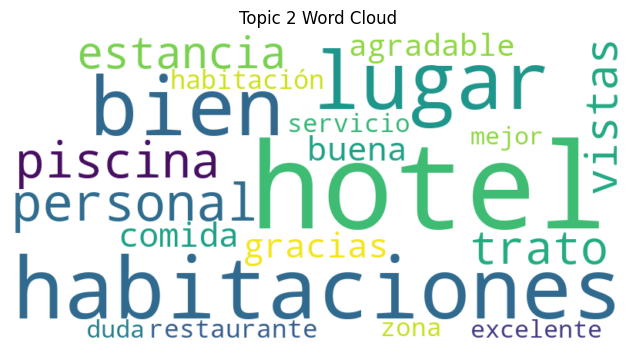

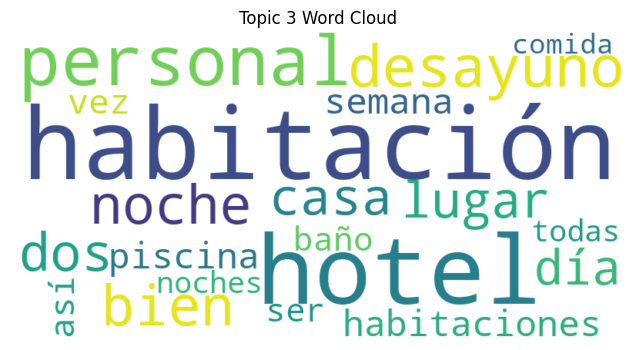

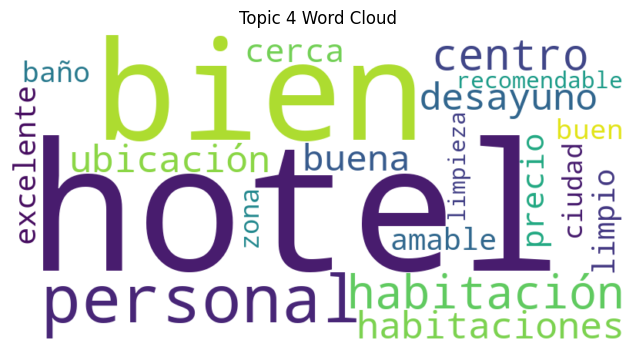

In [216]:
create_topic_wordclouds(lda_model4, 'lda_model4', num_topics)

In [217]:
# create_multiple_topic_wordclouds(lda_model4, num_topics)

In [218]:
intertopic_distance(lda_model4, 'lda_model4', corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.069691  0.071261       1        1  38.782766
0      0.122307  0.032159       2        1  27.662127
1     -0.076719 -0.034970       3        1  17.874146
2      0.024103 -0.068450       4        1  15.680961, topic_info=             Term         Freq        Total Category  logprob  loglift
75          lugar  2299.000000  2299.000000  Default  30.0000  30.0000
2          centro  3686.000000  3686.000000  Default  29.0000  29.0000
239       gracias  1156.000000  1156.000000  Default  28.0000  28.0000
55      excelente  2428.000000  2428.000000  Default  27.0000  27.0000
7      habitación  8898.000000  8898.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
607        vistas   302.152537  1810.403253   Topic4  -5.8418   0.0623
74   habitaciones   424.992392  5308.666396   Topic4  -5.5007  -0.6723
26       estancia   295.375921  1795.912409   Topic4  -5.8645   0.0477
94           baño   347.874132  3306.428869   Topic4  -5.7009  -0.3991
43          mejor   290.358556  2085.527854   Topic4  -5.8816  -0.1189

[409 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
5525       2  0.962719     1430
5525       4  0.038509     1430
996        2  0.022798  acogida
996        3  0.957497  acogida
996        4  0.022798  acogida
...      ...       ...      ...
111        4  0.066834     zona
11418      2  0.039003  árboles
11418      3  0.897071  árboles
11418      4  0.078006  árboles
7894       4  0.931508    éxito

[1000 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

---
## 6. Evaluation

**Coherence Score**: Coherence score quantifies the interpretability and consistency of topics in a topic model; higher coherence scores indicate more meaningful and coherent topics within the model.

**Perplexity**: Perplexity is a measure of how well a probabilistic model, such as a language model or a topic model, predicts a given dataset; lower perplexity values indicate that the model better captures the data's underlying patterns and is more confident in its predictions.

In [219]:
from gensim.models import CoherenceModel

In [220]:
# Evaluate Model 1
coherence_model1 = CoherenceModel(model=lda_model1, texts=texts, dictionary=id2word, coherence='c_v')
coherence1 = coherence_model1.get_coherence()
perplexity1 = lda_model1.log_perplexity(corpus)

In [221]:
# Evaluate Model 2
coherence_model2 = CoherenceModel(model=lda_model2, texts=texts, dictionary=id2word, coherence='c_v')
coherence2 = coherence_model2.get_coherence()
perplexity2 = lda_model2.log_perplexity(corpus)

In [222]:
# Evaluate Model 3
coherence_model3 = CoherenceModel(model=lda_model3, texts=texts, dictionary=id2word, coherence='c_v')
coherence3 = coherence_model3.get_coherence()
perplexity3 = lda_model3.log_perplexity(corpus)

In [223]:
# Evaluate Model 4
coherence_model4 = CoherenceModel(model=lda_model4, texts=texts, dictionary=id2word, coherence='c_v')
coherence4 = coherence_model4.get_coherence()
perplexity4 = lda_model4.log_perplexity(corpus)

### 6.1. Coherence scores

In [224]:
# Coherence scores
print(f"Coherence Score for Model 1: {coherence1}")
print(f"Coherence Score for Model 2: {coherence2}")
print(f"Coherence Score for Model 3: {coherence3}")
print(f"Coherence Score for Model 4: {coherence4}")

Coherence Score for Model 1: 0.31157072716856454
Coherence Score for Model 2: 0.3449582394211888
Coherence Score for Model 3: 0.31052544598190457
Coherence Score for Model 4: 0.35870865964304177


### 6.2. Perplexity scores

In [225]:
# Perplexity scores
print(f"Perplexity for Model 1: {perplexity1}")
print(f"Perplexity for Model 2: {perplexity2}")
print(f"Perplexity for Model 3: {perplexity3}")
print(f"Perplexity for Model 4: {perplexity4}")

Perplexity for Model 1: -8.157131508277912
Perplexity for Model 2: -7.854504326438835
Perplexity for Model 3: -8.019897986442905
Perplexity for Model 4: -7.793372003682351
